<a href="https://colab.research.google.com/github/nagusubra/ENDG511_Labs/blob/main/Lab2/ENDG_511_LAB_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ENDG-511 LAB 2 Assignment : Transfer Learning

Please direct any questions to Sampreet Vaidya: sampreet.vaidya@ucalgary.ca and Cc hatem.abouzeid@ucalgary.ca 

# Introduction

In this lab, you will implement tasks similar to the one presented in the [NIPS paper](https://arxiv.org/abs/1411.1792) discussed in the class.

When a model that has been trained for one task is repurposed for a different, related task this is known as transfer learning. When modelling the second task, transfer learning can enable quick advancement or improved performance. In transfer learning, the learned features from a base network that is trained on a base dataset and task,  are transferred to a second target network that is trained on a target dataset and task. If the traits are general—that is, applicable to both the base task and the target task—rather than task-specific, this procedure is more likely to succeed.

* Reference: 
https://keras.io/guides/transfer_learning/

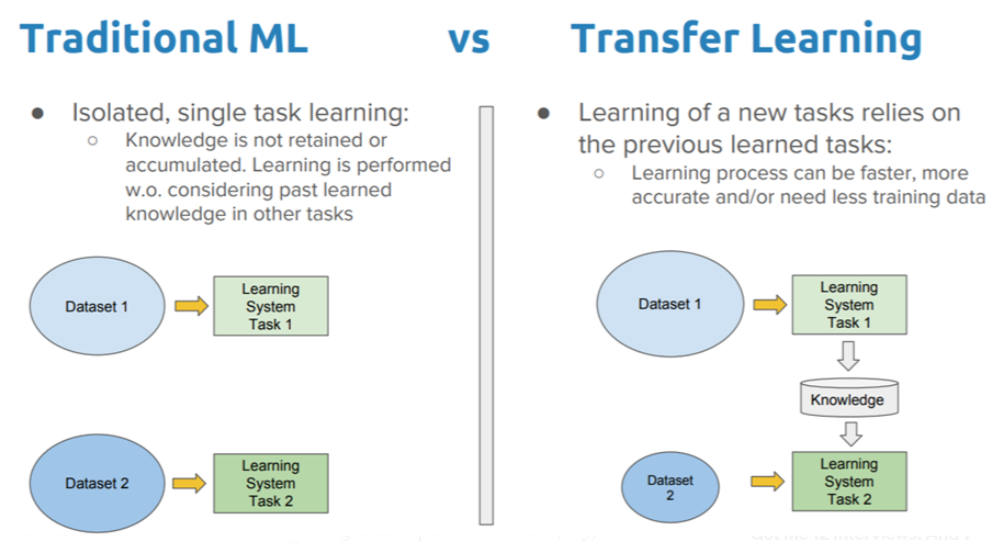


#LAB GOALS:

1) Analyse and observe transferablity of features in transfer learning following an approach similar to the experiements done in the NIPS paper.

2) Learn to conduct thorough experiments using loops, function calls, and saving of accuracy metrics. 

3) Develop a framework that you could re-use in your project if you incorporate transfer learning.

# Overview of the Assignment:

**Section 1) Transfer Learning on a Similar Dataset**: The CIFAR-10 dataset is divided into two sub-datasets, dataset A and dataset B. Dataset A will contain the first 5 classes while datset B will contain the other 5 classes. 

Note: The neural network architecture to use has been given to you. It is similar to Alexnet but with a few modifications. The required tasks are to:

      1.1) Train the main Dataset: Train the given model (7 main layers) for both the datasets. Trained model: baseA
      1.2) Evaluate transfer network 1 (AnB): Freeze baseA layers one by one upto 7 layers while intializing other layers randomly. Train all the models and store its accuracy, training convergence curve, and time taken for training. 
      1.3) Transfer network 2 (AnB+) : Similar to AnB, but this time, retraining of the copied layers is allowed.

**Section 2) Transfer Learning on a Different Dataset**: In this section, you have to observe the the effectiveness of feature transfer with a dissimilar dataset (C) that is provide.

      2.1) Transfer network 1 (AnC): Freeze baseA layers one by one upto 7 layers while intializing the rest of the layers randomly. Train all the models and store its accuracy, training convergence curve, and time taken for training.
      2.2) Transfer network 2 (AnC+) : Similar to AnC, but this time, retraining of the copied layers is allowed.

## How to submit the Assignment 

- You are required to sumbmit the completed python notebook and a pdf version of it in a Dropbox folder on D2L.
- This is an individual assignment, and all the assignements must be submitted individually.

- **Due Date: 10th February 2023**

###Notes: 

- This assignment can be completed directly on Google Colab, but you are free to choose any other computing resource. 
-  LAB sessions will be held to go over the main concepts and help you with the assignment.

# Section 1

1) Training the base model A for dataset A [ref [NIPS paper](https://arxiv.org/abs/1411.1792)]

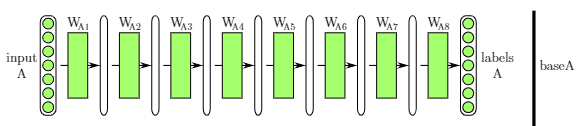


2) Observing and analysing the Transfer AnB and Transfer AnB+ network similar to the network in the paper.






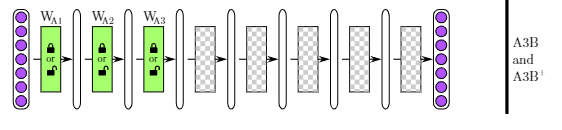

In [1]:
# mounting google drive (if you are using Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing Libraries

In [2]:
from tqdm import tqdm_notebook as tqdm
import tensorflow as tf
import os
import time
import pickle
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

### Loading the dataset

In [3]:
#directly loading the data from tensorflow dataset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

170498071/170498071 [==============================] - 6s 0us/step


### Different class names in the dataset

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

##Splitting of dataset

In [5]:
index_train_A, index_train_B, index_test_A, index_test_B=[],[],[],[]

#first five classes are added to the a list and next five classes are added to other list

for i in range(10):
  if i<5:
    index_train_A.extend(list(np.where(train_labels == [i])[0]))
    index_test_A.extend(list(np.where(test_labels == [i])[0]))
  else:
    index_train_B.extend(list(np.where(train_labels == [i])[0]))
    index_test_B.extend(list(np.where(test_labels == [i])[0]))

#creating new variables for train and test images
#adding the images based on the indices
xtrain_A=train_images[index_train_A]
ytrain_A=train_labels[index_train_A]
xtrain_B=train_images[index_train_B]
ytrain_B=train_labels[index_train_B]
xtest_A=test_images[index_test_A]
ytest_A=test_labels[index_test_A]
xtest_B=test_images[index_test_B]
ytest_B=test_labels[index_test_B]

for i in ytrain_B:
  i[0]=i[0]-5

for i in ytest_B:
  i[0]=i[0]-5

###Dataset A images

- Let us check what kind of images are in the first dataset A

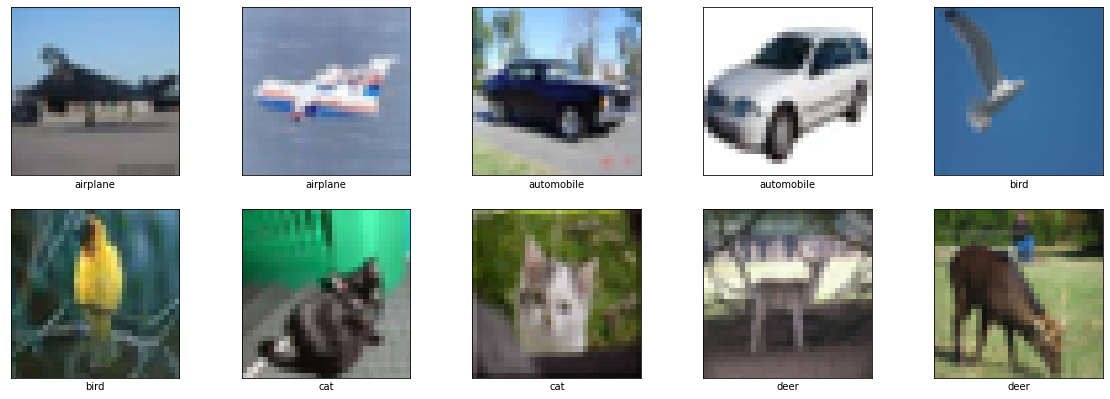

In [6]:
n=0
plt.figure(figsize=(20,18))
for i in range(10):
    n=n+2450
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(xtrain_A[n])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[ytrain_A[n][0]])
plt.show()

###Dataset B images

- SImilarly, Let us check what kind of images are in the first dataset B

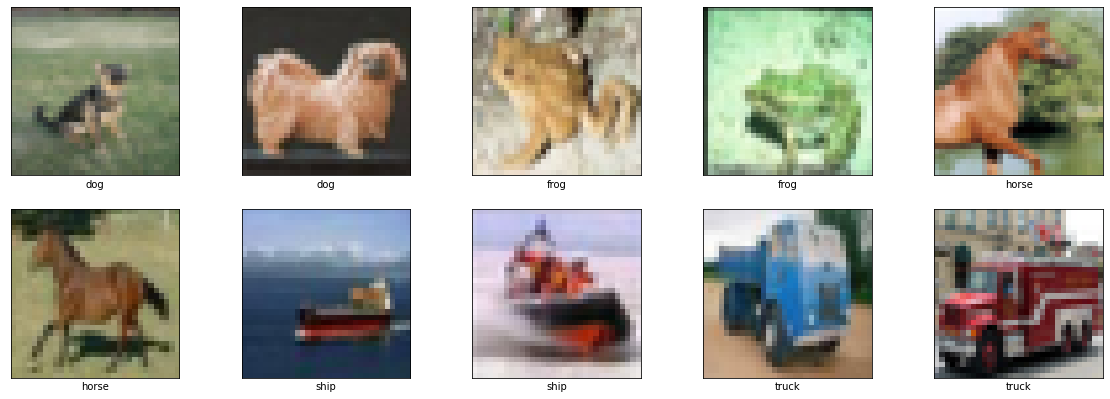

In [7]:
n=0
plt.figure(figsize=(20,18))
for i in range(10):
    n=n+2450
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(xtrain_B[n])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[ytrain_B[n][0]+5])
plt.show()

##Random Model Function

This function defines our architecture which is initialized randomly and will be used later.

In [8]:
import tensorflow 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten,Dropout,Input, AveragePooling2D, Activation,Conv2D, MaxPooling2D, BatchNormalization,Concatenate
def random_model_function():
  """ 
  Function to define a random model which can be used later while freezing and unfreezing
  """

  random_model = models.Sequential()
  random_model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='random_normal',bias_initializer='zeros',padding='same', input_shape=(32, 32, 3)))
  random_model.add(BatchNormalization())
  random_model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='random_normal',bias_initializer='zeros', padding='same'))
  random_model.add(BatchNormalization())
  random_model.add(MaxPool2D((2, 2))) 
  random_model.add(Dropout(0.2))
  random_model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='random_normal',bias_initializer='zeros', padding='same'))
  random_model.add(BatchNormalization())  
  random_model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='random_normal',bias_initializer='zeros', padding='same'))
  random_model.add(BatchNormalization())
  random_model.add(MaxPool2D((2, 2)))
  random_model.add(Dropout(0.3))
  random_model.add(Conv2D(128, (3, 3), activation='relu',kernel_initializer='random_normal',bias_initializer='zeros', padding='same'))
  random_model.add(BatchNormalization())
  random_model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='random_normal',bias_initializer='zeros', padding='same'))
  random_model.add(BatchNormalization())
  random_model.add(MaxPool2D((2, 2)))
  random_model.add(Dropout(0.4))
  random_model.add(Flatten())
  random_model.add(Dense(128, activation='relu', kernel_initializer='random_normal'))
  random_model.add(BatchNormalization())
  random_model.add(Dropout(0.5))
  random_model.add(Dense(5, activation='softmax'))
  return random_model

##Model Preparation Dataset A

Model architecture is similar to AlextNet (shown below) but modified in terms of filter size, number of filters etc. There are seven (7) layers in the defined architecture (in the code above) that we can transfer: 6 convulation layers and 1 dense layer

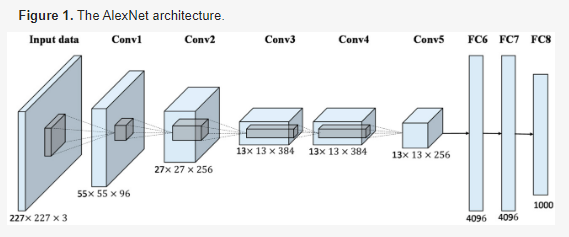

In [9]:
### defining a model architecture similar to Alexnet for this dataset
import tensorflow 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten,Dropout,Input, AveragePooling2D, Activation,Conv2D, MaxPooling2D, BatchNormalization,Concatenate
model = models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

# printing the model summary 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

##*Question 1* [0.5 marks]:

1) Describe the difference between these two callback functions.
  - What kind of diiference should we describe?
  - Thier application, what do they do, etc
  - syntax

Reference : https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback



2) Explain the reason why Sparse categorical entropy was used as loss function in the model compilation. 

- What should we explain and what are the expectations?
- why and when do we use it (general)?
- // not required Why doe we use Sparse categorical entropy in Section 1 and why we use categorical entropy in section 2?




Answer 1 :

1) The difference between the two callback functions are:

| Callback 1 | Callback 2 |
|------------|------------|
| - EarlyStopping: Stops training when a monitored metric (validation accuracy here) has stopped improving.| - Reduce learning rate when a metric (validation loss here) has stopped improving.|
| - We are monitoring the validation accuracy.| - We are monitoring the validation loss.|
| - The min_delta is 0.| - The min_delta is 0.0001.|
| - Any change in the validation accuracy greater than 0 is considered as an improvement.| - Any change in the validation loss greater than 0.0001 is considered as an improvement.|
| - The patience is 6. | - The patience is 4.|
| - After 6 epochs of no improvement, the training will be stopped.| - After 4 epochs of no improvement, the learning rate will be reduced by factor of 0.1 to retrain model.|
| - The learning rate is fixed ar 1e-3.| - The learning rate will reduce from 1e-4 to 1e-5 after patience value.|
| - There is no cooldown, the training is stopped when there is no improvement in validation accuracy. | - The cooldown is 0.|
| - Not applicabale here. | - It cools down for 0 epochs before resuming normal operation after lr has been reduced by 0.1 factor.|


2) The reason why Sparse categorical entropy was used as loss function in the model compilation:

It is used in multi-class classification model as a loss function, where the output label is an assigned integer value of 0, 1, 2, 3, etc.

1. Simplicity: Sparse categorical crossentropy is easy to implement and computationally efficient.

2. Multi-class compatibility: Sparse categorical crossentropy is designed for multi-class classification models. It is able to calculate the error between the predicted class probabilities and the true class labels to give the loss.

3. Handling of class imbalance: Sparse categorical crossentropy is able to handles the imbalance in the distribution of class labels. It solves this issue by treating each class label equally, regardless of its frequency in the training dataset.

4. Ability to incorporate class weights: Sparse categorical crossentropy also allows for the incorporation of class weights, which can be useful in cases where certain classes are more important to predict correctly than others.

5. Interpretability: The results produced by sparse categorical crossentropy are easy to interpret, as it outputs a categorical prediction for each instance in the dataset.

Overall, sparse categorical crossentropy is a widely used and well-established loss function for multi-class classification problems and provides a good balance between accuracy and computational efficiency.

In [ ]:
#Call back 1: 
base_learning_rate = 0.001
callback_1=tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    min_delta=0, 
    patience=6, 
    verbose=0, 
    mode='auto',
    baseline=None, 
    restore_best_weights=True)

#call back 2: 
callback_2= tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=4,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0)


callback_list=[callback_1,callback_2]

#compiling our Model for datasert
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# training the model and saving the model components history to history variable
history = model.fit(xtrain_A, ytrain_A, epochs=30, validation_data=(xtest_A, ytest_A),callbacks=callback_list)

Epoch 1/30
782/782 [==============================] - 17s 10ms/step - loss: 1.1472 - accuracy: 0.5684 - val_loss: 0.7713 - val_accuracy: 0.6928 - lr: 0.0010
Epoch 2/30
782/782 [==============================] - 7s 10ms/step - loss: 0.7549 - accuracy: 0.7038 - val_loss: 0.6596 - val_accuracy: 0.7468 - lr: 0.0010
Epoch 3/30
782/782 [==============================] - 7s 9ms/step - loss: 0.6439 - accuracy: 0.7607 - val_loss: 0.6738 - val_accuracy: 0.7554 - lr: 0.0010
Epoch 4/30
782/782 [==============================] - 7s 9ms/step - loss: 0.5719 - accuracy: 0.7901 - val_loss: 0.5645 - val_accuracy: 0.7890 - lr: 0.0010
Epoch 5/30
782/782 [==============================] - 7s 9ms/step - loss: 0.5149 - accuracy: 0.8103 - val_loss: 0.4717 - val_accuracy: 0.8278 - lr: 0.0010
Epoch 6/30
782/782 [==============================] - 7s 9ms/step - loss: 0.4731 - accuracy: 0.8268 - val_loss: 0.4402 - val_accuracy: 0.8420 - lr: 0.0010
Epoch 7/30
782/782 [==============================] - 7s 9ms/step -

### Plotting the results

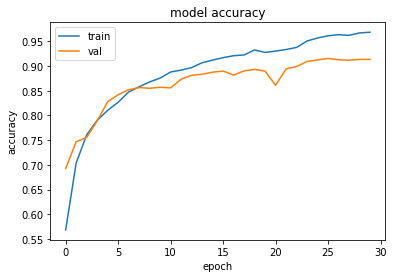

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

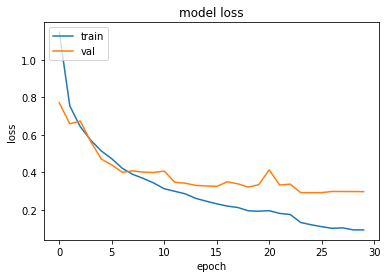

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [10]:
# Saving the whole model instead of just weights
!mkdir -p /content/drive/MyDrive/ENDG_511/saved_model
model.save('/content/drive/MyDrive/ENDG_511/saved_model/baseA_model')

#loading the saved model
baseA_model = tf.keras.models.load_model('/content/drive/MyDrive/ENDG_511/saved_model/baseA_model')

print('Number of layers in base model : ',len(baseA_model.layers))

Number of layers in base model :  23


##Transfer Network : AnB

## *Creating a Model Initialized with Random Weights*: 
Use the Random_model_function mentioned above to define a random model in a variable random_model.

In [11]:
random_model=random_model_function()
# compile model
random_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_8 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                      

In [12]:
random_model.layers

In [13]:
baseA_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

In [14]:
baseA_model.layers

# Testing transfer learning with fixed n number of layers

In [15]:
# # testing_model = Sequential() 
# # testing_model.add(baseA_model)

# i = -21

# transfer_learning_model = Sequential() # new squential model

# required_baseA_model_layers = baseA_model.layers[:i] # get first i layers from baseA 
# for pretrained_layer_in_baseA_model in required_baseA_model_layers:
#   pretrained_layer_in_baseA_model.trainable=False # set base A layer.trainable = False/True
#   transfer_learning_model.add(pretrained_layer_in_baseA_model) # add first i layers from baseA to new model

# required_random_model_layers = random_model.layers[i:] # Similarly, get last 7-i layers from random _model 
# for pretrained_layer_in_random_model in required_random_model_layers:
#   pretrained_layer_in_random_model.trainable=False # set random_model layer.trainable =True or False
#   transfer_learning_model.add(pretrained_layer_in_random_model) # add last 7-i layers from random model to new model

In [16]:
# # testing_model.summary()
# transfer_learning_model.summary()

##*Question 2 : Defining Structure for AnB* [2.5 marks]

Write code to define the structure of to train transfer network AnB. The first *n* layers should be copied from baseA model and rest (*7-n)* layers should be randomly initialsed. Wrap this code into a function that you can re-use for the remaining sections of the lab.

**Hints :** 

1) You can use for loop to define a new model, copy the n layers from baseA model while 7-n layers from random model used above.

We have 23 layers in each model. 7 layers are main.

      set a list of layer number, l  =[... ]
          for i in range():
                -> new squential model = 
                -> get first i layers from baseA 
                -> set base A layer.trainable = False/True
                -> add first i layers from baseA to new model
                -> Similarly, get last 7-i layers from random _model 
                -> set random_model layer.trainable =True or False
                -> add last 7-i layers from random model to new model

                # Use a list of layer numbers to spcify what to copy to new model

2) Here the loop will create 7 different networks with a different number of layers transfered.

3) Make sure you save all the accuracies while training in the loop.

4) You can also make use of the layout below (but that is not required if you want to write you own code from scratch).

In [18]:
def network_model(layerNum_list, base_model,random_model,
                  batch_size=254,IG_train=None,IG_test=None,
                  x_train=None,y_train=None,x_test=None,y_test=None,
                  Trainable=False,image=False):
  
  """
  layerNum_list= A list containing layer numbers from which seperation should happen between freezing and random. 
                 for example in this network: layers_num=[-21,-17,-13,-11,-7,-5,-2]

  base_model = trained model (base model)
  random_model = Model which is randomly initialized
  Trainable = Default : False. It defines if the base model layers are freezed or retraining is allowed.
  Image= Default : False. Whether the input data is from image generator class or not. 
  NOTE: If you are using image Generator class for training and testing data, please make sure you are setting image=True.
        Else you can directly provide the training and testing data.
  """
  
  #Empty dictionaries for saving each model's accuracies. 
  history={}
  y_pred={}
  time_={}
  evaluation={}
 

  # The core logic of AnB architecture 
  # Create a model in each out loop and evaluate it 
  for i in range(len(layerNum_list)):
    
    print ("\n\nThe partioning layer number: ", layerNum_list[i], "\n")

    transfer_learning_model = Sequential() # new squential model

    # Create the base_model layers that are transferred
    # for

    required_base_model_layers = base_model.layers[:layerNum_list[i]] # get first i layers from baseA 
    for pretrained_layer_in_base_model in required_base_model_layers:
      pretrained_layer_in_base_model.trainable = Trainable # set base A layer.trainable = False/True
      transfer_learning_model.add(pretrained_layer_in_base_model) # add first i layers from baseA to new model

    # Create the model layers that are randomly initialized
    # for

    required_random_model_layers = random_model.layers[layerNum_list[i]:] # Similarly, get last 7-i layers from random _model 
    for pretrained_layer_in_random_model in required_random_model_layers:
      transfer_learning_model.add(pretrained_layer_in_random_model) # add last 7-i layers from random model to new model

    # printing the summary to check trainable parameters after each loop

    transfer_learning_model.summary()

    #defining callbacks

    #Call back 1: 
    base_learning_rate = 0.001
    ES = tf.keras.callbacks.EarlyStopping(
                                            monitor='val_accuracy', 
                                            min_delta=0, 
                                            patience=6, 
                                            verbose=0, 
                                            mode='auto',
                                            baseline=None, 
                                            restore_best_weights=True
                                        )

    #call back 2: 
    RLR = tf.keras.callbacks.ReduceLROnPlateau(
                                                monitor='val_loss',
                                                factor=0.1,
                                                patience=4,
                                                verbose=0,
                                                mode='auto',
                                                min_delta=0.0001,
                                                cooldown=0,
                                                min_lr=0
                                              )


    # callback_list=[callback_1,callback_2]

    #compiling each Model

    transfer_learning_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    # training the model and saving the model components history to history variable
    # history = model.fit(xtrain_A, ytrain_A, epochs=30, validation_data=(xtest_A, ytest_A),callbacks=callback_list)

    #training each model.
    # saving the iteration's output (accuracies) to use it at a later stage

    print('\n MODEL TRAINING STARTED ... ')
    start_time = time.time()
    if (image):
      history[i] = transfer_learning_model.fit(IG_train,batch_size=254, epochs=15,validation_data=IG_test,callbacks=[ES,RLR])
    else:
      history[i] = transfer_learning_model.fit(x_train, y_train, epochs=40, validation_data=(x_test, y_test),callbacks=[ES,RLR],verbose=0)  
    time_[i] = time.time() - start_time
    print('\n MODEL TRAINING ENDED ... ')
    
    if(image):
      y_pred[i]=transfer_learning_model.predict(IG_test,verbose=0)
      evaluation[i] = transfer_learning_model.evaluate(IG_test,verbose=0)
    else:
      y_pred[i]=transfer_learning_model.predict(x_test,verbose=0)
      evaluation[i] = transfer_learning_model.evaluate(x_test, y_test,verbose=0)

#saving the iteration's output (accuracies) to use it at a later stage

  return history, time_, y_pred, evaluation  



The partioning layer number:  -21 


 MODEL TRAINING STARTED ... 

 MODEL TRAINING ENDED ... 


The partioning layer number:  -17 


 MODEL TRAINING STARTED ... 

 MODEL TRAINING ENDED ... 


The partioning layer number:  -13 


 MODEL TRAINING STARTED ... 

 MODEL TRAINING ENDED ... 


The partioning layer number:  -11 


 MODEL TRAINING STARTED ... 

 MODEL TRAINING ENDED ... 


The partioning layer number:  -7 


 MODEL TRAINING STARTED ... 

 MODEL TRAINING ENDED ... 


The partioning layer number:  -5 


 MODEL TRAINING STARTED ... 

 MODEL TRAINING ENDED ... 


The partioning layer number:  -2 


 MODEL TRAINING STARTED ... 

 MODEL TRAINING ENDED ... 


# AnB training

In [ ]:
 # Code to call this function

layers_num = [-21,-17,-13,-11,-7,-5,-2] #layer number list at which seperation should happen.  

# these are the list index of the important layers
# 0 to -21 from baseA and then -21 to 23 from Random model

 # function call

history_AnB, time_AnB, y_pred_AnB, evaluation_AnB  = network_model(
                                                                    layers_num,baseA_model,
                                                                    random_model,
                                                                    batch_size=254,
                                                                    IG_train=None,
                                                                    IG_test=None,
                                                                    x_train=xtrain_B,
                                                                    y_train=ytrain_B,
                                                                    x_test=xtest_B,
                                                                    y_test=ytest_B,
                                                                    Trainable=False,
                                                                    image=False
                                                                  )


# xtrain_A=train_images[index_train_A]
# ytrain_A=train_labels[index_train_A]
# xtrain_B=train_images[index_train_B]
# ytrain_B=train_labels[index_train_B]
# xtest_A=test_images[index_test_A]
# ytest_A=test_labels[index_test_A]
# xtest_B=test_images[index_test_B]
# ytest_B=test_labels[index_test_B]

##Saving 

You can save your different variables for later use in a pickle file in the following format. 

In [ ]:
# a_file = open("/content/drive/MyDrive/ENDG_511/variable.pkl", "wb")
# pickle.dump(Variable_to_be_saved, a_file)
# a_file.close()

# For example saving these variables in a pickle file for future reference

a_file = open("/content/drive/MyDrive/ENDG_511/history_AnB.pkl", "wb")
pickle.dump(history_AnB, a_file)
a_file.close()

a_file = open("/content/drive/MyDrive/ENDG_511/y_pred_AnB.pkl", "wb")
pickle.dump(y_pred_AnB, a_file)
a_file.close()

a_file = open("/content/drive/MyDrive/ENDG_511/evaluation_AnB.pkl", "wb")
pickle.dump(evaluation_AnB, a_file)
a_file.close()

a_file = open("/content/drive/MyDrive/ENDG_511/time_AnB.pkl", "wb")
pickle.dump(time_AnB, a_file)
a_file.close()

##Transfer Network : AnB+



## *Question 3: [0.5 marks]*

Structure and train a network AnB+ (similar to AnB), in which retraining of the copied baseA model layers is allowed, i,e : 

    layers.trainable = True

Re-use the function you wrote in Q2.

In [21]:
history_AnB_plus, time_AnB_plus, y_pred_AnB_plus, evaluation_AnB_plus  = network_model(
                                                                                        layers_num,baseA_model,
                                                                                        random_model,
                                                                                        batch_size=254,
                                                                                        IG_train=None,
                                                                                        IG_test=None,
                                                                                        x_train=xtrain_B,
                                                                                        y_train=ytrain_B,
                                                                                        x_test=xtest_B,
                                                                                        y_test=ytest_B,
                                                                                        Trainable=True,
                                                                                        image=False
                                                                                      )



The partioning layer number:  -21 


 MODEL TRAINING STARTED ... 

 MODEL TRAINING ENDED ... 


The partioning layer number:  -17 


 MODEL TRAINING STARTED ... 

 MODEL TRAINING ENDED ... 


The partioning layer number:  -13 


 MODEL TRAINING STARTED ... 

 MODEL TRAINING ENDED ... 


The partioning layer number:  -11 


 MODEL TRAINING STARTED ... 

 MODEL TRAINING ENDED ... 


The partioning layer number:  -7 


 MODEL TRAINING STARTED ... 

 MODEL TRAINING ENDED ... 


The partioning layer number:  -5 


 MODEL TRAINING STARTED ... 

 MODEL TRAINING ENDED ... 


The partioning layer number:  -2 


 MODEL TRAINING STARTED ... 

 MODEL TRAINING ENDED ... 


## Results


## *Question 4 :* [1.5 marks]

1) Plot (Scatter plot or line plot) the different accuracies obtained when performing Tranfer Learning of the various AnB and AnB+ networks trained in Q2 and Q3. This must be similar to figure 3 of the NIPS paper. Discuss your observations on the plot obtained.

2) Plot the accuracies vs epochs for the different accuracies obtained when performing Tranfer Learning of the various AnB and AnB+ networks trained in Q2 and Q3 (A helper function is provided for this below). This plot will show the convergence behavior of the different networks and how many epochs where needed during training. Discuss your observations on the plots obtained.

3) Plot (Scatter plot or line plot) the training time taken when performing Tranfer Learning of the various AnB and AnB+ networks trained in Q2 and Q3. Discuss your observations on the plot obtained.


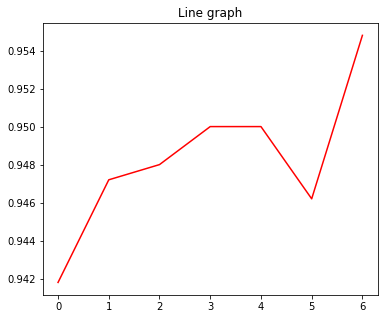

In [31]:
#1
plt.rcParams["figure.figsize"] = (6,5)

def plot_different_accuracies(evaluation_list, Graph_text):

  test_acc_list = []
  for i in range(len(evaluation_list)):

    test_loss, test_acc = evaluation_list[i]
    test_acc_list.append(test_acc)

  y = np.array(test_acc_list)
  x = np.array(range(len(evaluation_list)))

  plt.title(Graph_text)
  plt.plot(x, y, color="red")

  plt.show()

  # return test_acc_list

Observations:

**Transfer model AnB**

1. The AnB model's accuracy tends to become lower when we adopt/transfer more layers from model A.

2. The AnB model's accuracy is good enough for the first 2 transfered layers from model A. But once we start to transfer the 3rd layer onwards from model A to AnB, we see that the wieghts do not really work out on dataset B.

3. The main reason for this to happens is because of fragile co-adaption.



**Transfer model AnB+**

1. The AnB+ model's accuracy tends to become higher when we adopt/transfer more layers from model A.


In [ ]:
plot_different_accuracies(evaluation_AnB, Graph_text="AnB Accuracy graph")
plot_different_accuracies(evaluation_AnB_plus, Graph_text="AnB+ Accuracy graph")

In [19]:
plt.rcParams["figure.figsize"] = (18,15)
def plot_history(history,freezed=True):
  fig, ax = plt.subplots(3,3)#,sharey=True,sharex=True)
  n=0
  for i in ax:
    for j in i:
      if n>6:
        break
      j.plot(history[n].history['loss'],label='Training loss')
      j.plot(history[n].history['val_loss'],label='Validation loss')
      j.plot(history[n].history['accuracy'],label='Training Accuracy')
      j.plot(history[n].history['val_accuracy'],label='Validation Accuracy')
      if freezed:
        title = 'Base Model {} Layers Freezed'
      else :
        title = 'Base Model {} Layers Retrained'
      j.set_title(title.format(n+1))
      j.set_ylabel('loss')
      j.set_xlabel('epochs')
      j.legend(loc='best')
      n=n+1
  fig.delaxes(ax[2,1])
  fig.delaxes(ax[2,2])
  plt.show()

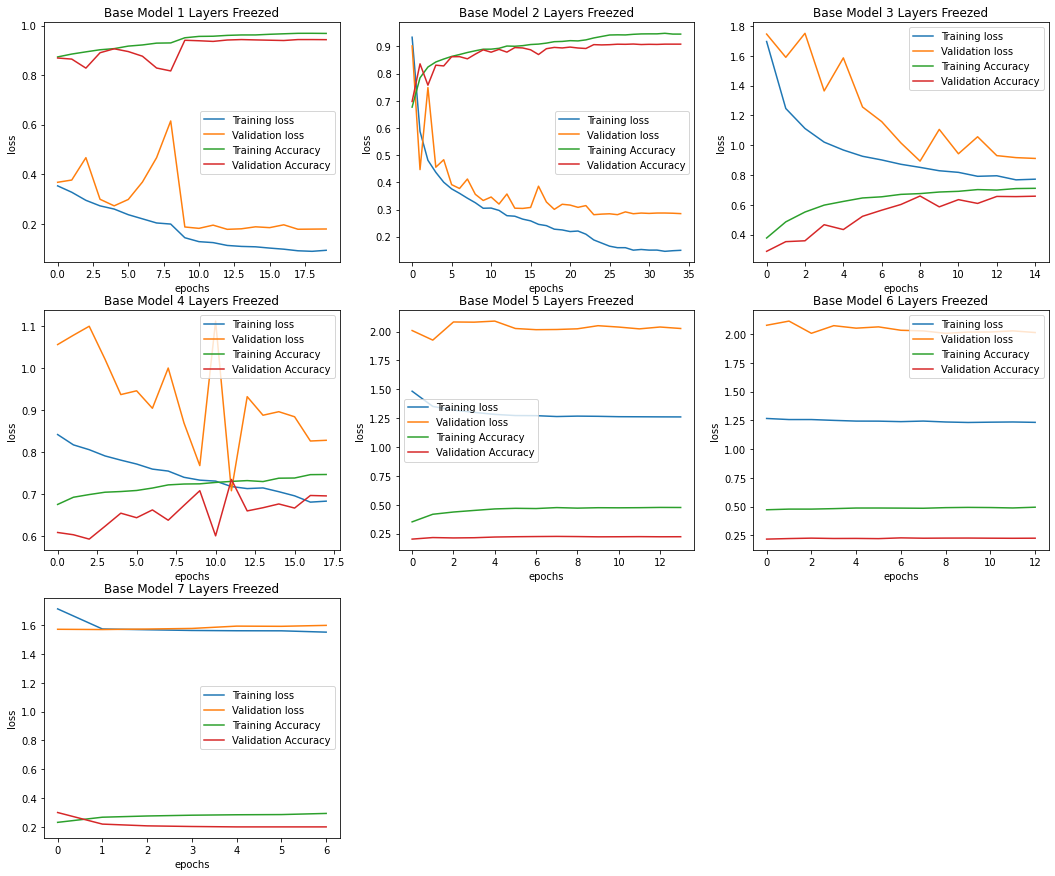

In [20]:
# use of the function above
plot_history(history_AnB)

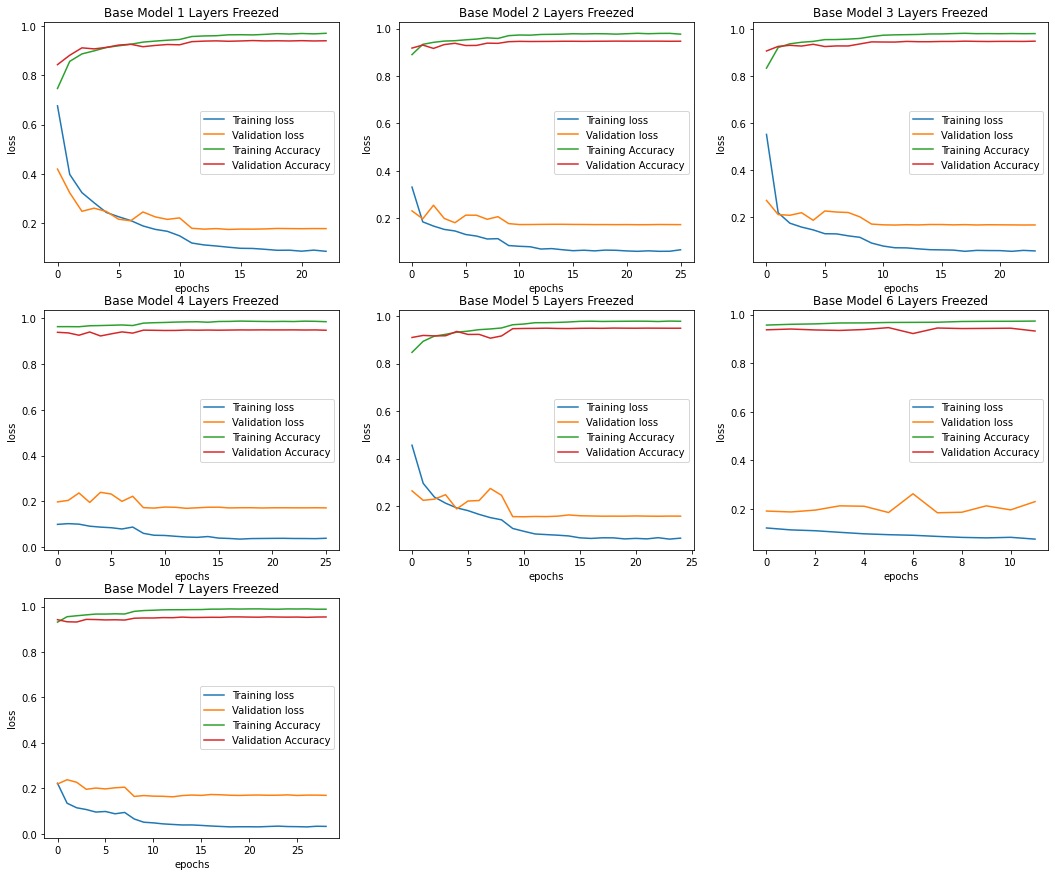

In [23]:
# use of the function above
plot_history(history_AnB_plus)

#Section 2

This section is very much similar to Section 1 but the major change now is the use of a very different dataset.





## Loading Dissimilar Dataset C

## Installing Packages

In [32]:
!pip install cv
#to unrar the given file
!pip install pyunpack
!pip install patool
# This chunk works.
!pip uninstall --yes gdown # After running this line, restart Colab runtime.
!pip install gdown -U --no-cache-dir

#will load a zip version of the dataset to ENDG 511 folder in you
import gdown
url = 'https://drive.google.com/drive/folders/1JBYELRCoWqMMvyvjsFp7xsZifJX0x2sQ?usp=sharing'
gdown.download_folder(url)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 KB 6.6 MB/s eta 0:00:00
Found existing installation: gdown 4.4.0
Uninstalling gdown-4.4.0:
  Successfully uninstalled gdown-4.4.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Retrieving folder list


Processing file 1_iYP56MlH1YqDQHqIL4ihDewjzawHGl2 rvl-cdip.rar
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=1_iYP56MlH1YqDQHqIL4ihDewjzawHGl2
To: /content/ENDG_511/rvl-cdip.rar
100%|██████████| 4.66G/4.66G [00:24<00:00, 193MB/s]
Download completed


['/content/ENDG_511/rvl-cdip.rar']

## Extracting the dataset

In [33]:
from pyunpack import Archive
#extract the file in the dest. folder
# Use : Astract(source .rar file).extractall(destination folder)
Archive('/content/ENDG_511/rvl-cdip.rar').extractall('/content/sample_data')

## Reading dataset

In [34]:
#reading the path file in pandas dataframe
data=pd.read_csv('/content/sample_data/labels_final.csv')
data.head()

,path,label
0,imagesv/v/o/h/voh71d00/509132755+-2755.tif,3
1,imagesl/l/x/t/lxt19d00/502213303.tif,3
2,imagesx/x/e/d/xed05a00/2075325674.tif,2
3,imageso/o/j/b/ojb60d00/517511301+-1301.tif,3
4,imagesq/q/z/k/qzk17e00/2031320195.tif,7


## Creating a subset of dataset

In [35]:
#creating a subset of dataset and selection those labels which are divided by 3
from sklearn.utils import shuffle
labels=['letter','form','email','handwritten','advertisement','scientific report','scientific publication','specification',
        'file folder','news article','budget','invoice','presentation','questionnaire','resume','memo']

dataset_C=data.loc[data['label'] == 0 ]

for i in range(4,len(labels)):
    if i%3==0:
        dataset_C=dataset_C.append(data.loc[data['label'] == i ])

dataset_C = shuffle(dataset_C)

for i in range(len(labels)):
    if i%3==0:
        dataset_C.loc[data['label'] == i,'label' ] = labels[i] 

dataset_C.reset_index(inplace=True, drop=True)

In [36]:
#value counts of different labels in our subset
dataset_C['label'].value_counts()

letter                    3016
presentation              3006
news article              3002
memo                      2996
scientific publication    2985
Name: label, dtype: int64

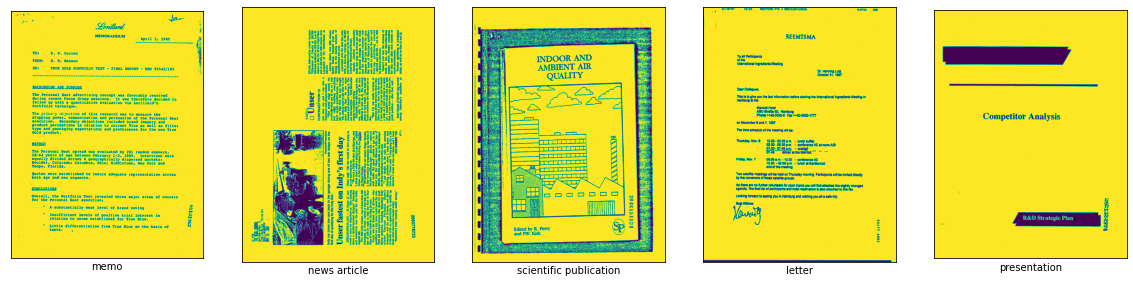

In [37]:
# Let us see how does our dataset look like
import cv2

plt.rcParams["figure.figsize"] = (20,20)
fig, ax = plt.subplots(1,5)
n=0
for col in ax:
  n=n+100
  img = cv2.imread('/content/sample_data/data_final/'+dataset_C['path'][n], cv2.IMREAD_UNCHANGED)
  col.imshow(img)
  col.set_xticks([])
  col.set_yticks([])
  col.set_xlabel(dataset_C['label'][n])
plt.show()

In [38]:
from sklearn.model_selection import train_test_split
#splitting the data into train and test using 80/20 ratio
train_C,test_C=train_test_split(dataset_C, test_size=0.2, stratify=dataset_C['label'])

In [39]:
##Image data Generator class
ImageFlow = tf.keras.preprocessing.image.ImageDataGenerator()
# fitting the data to Image data generator.
#using the 
IG_train_C = ImageFlow.flow_from_dataframe(train_C,directory='/content/sample_data/data_final',x_col='path',
                                                     y_col='label',batch_size=100,seed=30,class_mode='categorical',target_size=(32,32))
# Write ImageGenerator_test as well
IG_test_C = ImageFlow.flow_from_dataframe(test_C,directory='/content/sample_data/data_final',x_col='path',
                                                     y_col='label',batch_size=100,seed=30,class_mode='categorical',target_size=(32,32))

Found 12004 validated image filenames belonging to 5 classes.
Found 3001 validated image filenames belonging to 5 classes.



1) Loading our pretrained baseA model 

2) And initialize it to the model with random weights.





In [40]:
#example
#baseA_model = tf.keras.models.load_model('/content/drive/MyDrive/ENDG_511/saved_model/basA_model')

random_model=  random_model_function()



## Transfer Network AnC



In [44]:
def network_model_CategoricalCrossentropy(layerNum_list, base_model,random_model,
                  batch_size=254,IG_train=None,IG_test=None,
                  x_train=None,y_train=None,x_test=None,y_test=None,
                  Trainable=False,image=False):
  
  """
  layerNum_list= A list containing layer numbers from which seperation should happen between freezing and random. 
                 for example in this network: layers_num=[-21,-17,-13,-11,-7,-5,-2]

  base_model = trained model (base model)
  random_model = Model which is randomly initialized
  Trainable = Default : False. It defines if the base model layers are freezed or retraining is allowed.
  Image= Default : False. Whether the input data is from image generator class or not. 
  NOTE: If you are using image Generator class for training and testing data, please make sure you are setting image=True.
        Else you can directly provide the training and testing data.
  """
  
  #Empty dictionaries for saving each model's accuracies. 
  history={}
  y_pred={}
  time_={}
  evaluation={}
 

  # The core logic of AnB architecture 
  # Create a model in each out loop and evaluate it 
  for i in range(len(layerNum_list)):
    
    print ("\n\nThe partioning layer number: ", layerNum_list[i], "\n")

    transfer_learning_model = Sequential() # new squential model

    # Create the base_model layers that are transferred
    # for

    required_base_model_layers = base_model.layers[:layerNum_list[i]] # get first i layers from baseA 
    for pretrained_layer_in_base_model in required_base_model_layers:
      pretrained_layer_in_base_model.trainable = Trainable # set base A layer.trainable = False/True
      transfer_learning_model.add(pretrained_layer_in_base_model) # add first i layers from baseA to new model

    # Create the model layers that are randomly initialized
    # for

    required_random_model_layers = random_model.layers[layerNum_list[i]:] # Similarly, get last 7-i layers from random _model 
    for pretrained_layer_in_random_model in required_random_model_layers:
      transfer_learning_model.add(pretrained_layer_in_random_model) # add last 7-i layers from random model to new model

    # printing the summary to check trainable parameters after each loop

    transfer_learning_model.summary()

    #defining callbacks

    #Call back 1: 
    base_learning_rate = 0.001
    ES = tf.keras.callbacks.EarlyStopping(
                                            monitor='val_accuracy', 
                                            min_delta=0, 
                                            patience=6, 
                                            verbose=0, 
                                            mode='auto',
                                            baseline=None, 
                                            restore_best_weights=True
                                        )

    #call back 2: 
    RLR = tf.keras.callbacks.ReduceLROnPlateau(
                                                monitor='val_loss',
                                                factor=0.1,
                                                patience=4,
                                                verbose=0,
                                                mode='auto',
                                                min_delta=0.0001,
                                                cooldown=0,
                                                min_lr=0
                                              )


    # callback_list=[callback_1,callback_2]

    #compiling each Model

    transfer_learning_model.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])

    # training the model and saving the model components history to history variable
    # history = model.fit(xtrain_A, ytrain_A, epochs=30, validation_data=(xtest_A, ytest_A),callbacks=callback_list)

    #training each model.
    # saving the iteration's output (accuracies) to use it at a later stage

    print('\n MODEL TRAINING STARTED ... ')
    start_time = time.time()
    if (image):
      history[i] = transfer_learning_model.fit(IG_train,batch_size=254, epochs=15,validation_data=IG_test,callbacks=[ES,RLR])
    else:
      history[i] = transfer_learning_model.fit(x_train, y_train, epochs=40, validation_data=(x_test, y_test),callbacks=[ES,RLR],verbose=0)  
    time_[i] = time.time() - start_time
    print('\n MODEL TRAINING ENDED ... ')
    
    if(image):
      y_pred[i]=transfer_learning_model.predict(IG_test,verbose=0)
      evaluation[i] = transfer_learning_model.evaluate(IG_test,verbose=0)
    else:
      y_pred[i]=transfer_learning_model.predict(x_test,verbose=0)
      evaluation[i] = transfer_learning_model.evaluate(x_test, y_test,verbose=0)

#saving the iteration's output (accuracies) to use it at a later stage

  return history, time_, y_pred, evaluation  
 


 # Code to call this function

layers_num = [-21,-17,-13,-11,-7,-5,-2] #layer number list at which seperation should happen.  

##*Question 5: [0.5 marks]*

Similar to the transfer network AnB trained in the above section, in this question, we have to train Network AnC for dataset C and record accuracies.
Re-use the function you created earlier for part1.

Note: Since its a large dataset, each epoch can some time, so if you are using any constrained resource, you can train it for fewer epochs and use a good enough batch size

In [ ]:
history_AnC, time_AnC, y_pred_AnC, evaluation_AnC  = network_model_CategoricalCrossentropy(
                                                                    layers_num, baseA_model,
                                                                    random_model,
                                                                    batch_size=254,
                                                                    IG_train=IG_train_C,
                                                                    IG_test=IG_test_C,
                                                                    Trainable=False,
                                                                    image=True
                                                                  )



The partioning layer number:  -21 


 MODEL TRAINING STARTED ... 
Epoch 1/15
121/121 [==============================] - 73s 549ms/step - loss: 1.3015 - accuracy: 0.4959 - val_loss: 1.1795 - val_accuracy: 0.5661 - lr: 0.0010
Epoch 2/15
121/121 [==============================] - 50s 412ms/step - loss: 1.2196 - accuracy: 0.5242 - val_loss: 1.1897 - val_accuracy: 0.5205 - lr: 0.0010
Epoch 3/15
121/121 [==============================] - 46s 383ms/step - loss: 1.1395 - accuracy: 0.5505 - val_loss: 1.2608 - val_accuracy: 0.5465 - lr: 0.0010
Epoch 4/15
121/121 [==============================] - 40s 330ms/step - loss: 1.0923 - accuracy: 0.5668 - val_loss: 1.0536 - val_accuracy: 0.5935 - lr: 0.0010
Epoch 5/15
121/121 [==============================] - 39s 324ms/step - loss: 1.0729 - accuracy: 0.5746 - val_loss: 1.0871 - val_accuracy: 0.5791 - lr: 0.0010
Epoch 6/15
121/121 [==============================] - 40s 330ms/step - loss: 1.0207 - accuracy: 0.5974 - val_loss: 1.0315 - val_accuracy: 0.59

In [ ]:
plot_history(history_AnC)

##Transfer network AnC+

## *Question 6:[0.5 marks]*

Similar to the trnasfer network AnB+ trained earlier, in this question, we have to train network AnC+ to record accuracies at different layers. Re-use the function you created earlier for part1.



##Result Analysis



##*Question 7: [1.5 marks]* 

1) Plot (Scatter plot or line plot) the different accuracies obtained when performing Tranfer Learning of the various AnC and AnC+ networks trained in Q5 and Q6. This must be similar to figure 3 of the NIPS paper. Discuss your observations on the plot obtained.

2) Plot the accuracies vs epochs for the different accuracies obtained when performing Tranfer Learning of the various AnC and AnC+ networks trained in Q5 and Q6 (A helper function is provided for this below). This plot will show the convergence behavior of the different networks and how many epochs where needed during training. Discuss your observations on the plots obtained.

3) Plot (Scatter plot or line plot) the training time taken when performing Tranfer Learning of the various AnB and AnB+ networks trained in Q5 and Q6. Discuss your observations on the plot obtained.


##*Question 8: [0.5 marks]*

Write the observations between the accuracies obtained in AnB, AnB+, AnC and AnC+ plots obtained. Be sure to include your observations on the relative differences between AnC vs AnC+, and AnB vs AnB+.